## Phase 2: Video sequence feature extraction + LSTM model training 
This file extracts features from the train set of ENTERFACE dataset using the fine-tuned CNN from phase 1. 
It gathers 16 frames from a video clip and then extracts a feature vector of length (16, 2048). These are extracted and stored as training_features and validation_features. These features are then fed to train an LSTM network. The file contains steps for feature extraction -> model training -> model evaluation. Overall test accuracy on this dataset is ~ 42% but precision and recall vary a lot across emotions

In [ ]:
# import zipfile36 as zipfile 
# from zipfile import ZipFile

# filename = 'modifed_ENTERFACE.zip'
# with ZipFile(filename,'r') as zip:
#     zip.extractall(path= "eInterface_dataset")

In [1]:
import os
import numpy as np 
import cv2
from os import listdir
import shutil
from keras.models import Model, load_model
import matplotlib
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
import keras
from keras.preprocessing.image import img_to_array, load_img
import pickle as pkl 
from collections import deque
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM, BatchNormalization

import seaborn
from mtcnn.mtcnn import MTCNN
import time
import dlib
#pip install mtcnn

Using TensorFlow backend.
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
new_model = keras.models.load_model('custom_vgg_model_preproc1.h5')
#new_model = keras.models.load_model('custom_vgg_model6.h5')
new_model.layers.pop()
new_model = Model(inputs=new_model.inputs, outputs=new_model.layers[-1].output)
new_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_____

In [ ]:
# emotions = ['anger', 'disgust','fear', 'happiness', 'sadness', 'surprise']
# destination_path = "eInterface_dataset/eInterface/training_features/features_overlap_16_6classes"
# #code to create directories in features folder
# for emotion in emotions :
#     destination_emotion = os.path.join(destination_path, emotion)
#     if os.path.exists(destination_emotion):
#         os.system('rm -rf {}'.format(destination_emotion))

#     if not os.path.exists(destination_emotion):
#         os.system('mkdir {}'.format(destination_emotion))

        
# emotions = ['anger', 'disgust','fear', 'happiness', 'sadness', 'surprise']
# destination_path = "eInterface_dataset/eInterface/validation_features/features_nooverlap_16_6classes"
# #code to create directories in features folder
# for emotion in emotions :
#     destination_emotion = os.path.join(destination_path, emotion)
#     if os.path.exists(destination_emotion):
#         os.system('rm -rf {}'.format(destination_emotion))

#     if not os.path.exists(destination_emotion):
#         os.system('mkdir {}'.format(destination_emotion))


In [3]:
from keras_vggface import utils

detector = dlib.get_frontal_face_detector()

# x = image.img_to_array(x)
#     #x = face_detection(x)
#     x = np.expand_dims(x, axis=0)  
#     x = utils.preprocess_input(x, version=1)
    
#Extract features
def process_frame(queue):
    batchImages = np.stack(queue)
    features = new_model.predict(batchImages)
    return features

def extract_features_woverlap(queue,label,i,vid_file_name, features_path):    
    features_files = features_path
    window = 0
    for _ in range(len(queue)):
        if len(queue[window:window+16]) < 8:  #discard frames if leftover is less than half the window 
            break    
        features = process_frame(queue[window:window+16])
        print(np.shape(features),i)
        class_label=label
        output_filename = os.path.join(features_files, str(label), str(i) + '.pkl')
        out = {'class_label': class_label, 'features': features, 'vid_file': vid_file_name}
        with open(output_filename, 'wb') as w:
            pkl.dump(out, w)
        window += 8
        #window += 16
        i += 1
    return i
    
def extract_frames(file, source_path, vid_file_name,label,i,features_path):
    video = cv2.VideoCapture(source_path)
    count = 0
    queue = []
    while True:
        (grabbed, frame) = video.read()
        if not grabbed:
            print("not grabbed")
            break
        
#         faces = detector.detect_faces(frame)
#         if faces !=[]:
#             x1, y1, width, height = faces[0]['box']
#             x2, y2 = x1 + width, y1 + height
#             face = frame[y1:y2, x1:x2] 
        faces = detector(frame)
        #if faces != []:
        try:
            for face in faces:
                #for face in faces:
                x1 = face.left()
                y1 = face.top()
                x2 = face.right()
                y2 = face.bottom()
                frame = frame[y1:y2, x1:x2]
                frame = cv2.resize(frame, (224, 224)).astype("float32")
                #x = np.expand_dims(frame, axis=0)  
                x = utils.preprocess_input(frame, version=1)

                #cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX)
                #norm_image = cv2.normalize(frame, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                #queue.append(norm_image)
                queue.append(x)
        except:
            pass
            
        if len(queue) >= 180:
            break
    #extract_features(queue, label, i)
    i = extract_features_woverlap(queue,label,i, vid_file_name,features_path)
    return(i)

def video_fetch(dataset_path, features_path):
    
    count_unknown, i = 0,0
    queue = []
    
    t0 = time.time()

    for (root,dirs,files) in os.walk(dataset_path, topdown=True): 
        for file in files:
            if str(file) != "Thumbs.db":
                if not str(file).startswith('.'):
                    source_path = os.path.join(root,file)
                    #print(source_path)
                    if str(source_path).find("fear") > 0:
                        #vid_file_name = 'fear{}'.format(i)+'.mp4'
                        vid_file_name = str(file)
                        label = "fear"

                    elif str(source_path).find("happiness") > 0 :
                        #vid_file_name = 'happiness{}'.format(i)+'.mp4'
                        vid_file_name = str(file)
                        label = "happiness"


                    elif str(source_path).find("sadness") > 0:
                        #print(str(root).find("sadness"))
                        #vid_file_name = 'sadness{}'.format(i)+'.mp4'
                        vid_file_name = str(file)
                        label = "sadness"

                    elif str(str(source_path)).find("surprise") > 0:
                        #vid_file_name = 'surprise{}'.format(i)+'.mp4'
                        vid_file_name = str(file)
                        label = "surprise"

                    elif str(str(source_path)).find("anger") > 0 :
                        #vid_file_name = 'anger{}'.format(i)+'.mp4'
                        vid_file_name = str(file)
                        label = "anger"

                    elif str(source_path).find("disgust") > 0 :
                        #vid_file_name = 'disgust{}'.format(i)+'.mp4'
                        vid_file_name = str(file)
                        label = "disgust"

                    else : 
                        #print(str(source_path))
                        vid_file_name = "unknown"
                        count_unknown +=1

                    if vid_file_name != "unknown":
                        #print(vid_file_name)
                        #pass
                        i = extract_frames(file, source_path, vid_file_name, label,i,features_path)
                        i += 1
    print(count_unknown)
    t1 = time.time()
    print("time elapsed",t1-t0)

In [ ]:
#IGNORE THIS CELL
#features_train_24 = "eInterface_dataset/eInterface/training_features/features_overlap_24"
#features_val_24 = "eInterface_dataset/eInterface/validation_features/features_overlap_24" 
#features_train_16 = "eInterface_dataset/eInterface/training_features/features_overlap_16"
#features_val_16 = "eInterface_dataset/eInterface/validation_features/features_overlap_16"
# training_dataset_path = "eInterface_dataset/modifed_ENTERFACE/training_set"
# validation_dataset_path = "eInterface_dataset/modifed_ENTERFACE/validation_set"
#video_fetch(training_dataset_path, features_train_24)
#video_fetch(validation_dataset_path, features_val_24)

In [ ]:
training_dataset_path = "eInterface_dataset/modifed_ENTERFACE/training_set"
validation_dataset_path = "eInterface_dataset/modifed_ENTERFACE/validation_set"

detector = dlib.get_frontal_face_detector()
features_train_16_6classes = "eInterface_dataset/eInterface/training_features/features_overlap_16_6classes"
#video_fetch(training_dataset_path, features_train_16_6classes)

In [ ]:
#detector = dlib.get_frontal_face_detector()
features_val_16_6classes = "eInterface_dataset/eInterface/validation_features/features_nooverlap_16_6classes"
video_fetch(validation_dataset_path, features_val_16_6classes)
#video_fetch(training_dataset_path, features_val_16)

In [4]:
#load video features
t0 = time.time()
#training_features_path = "eInterface_dataset/eInterface/training_features/features_overlap_16"
training_features_path = "eInterface_dataset/eInterface/training_features/features_overlap_16_6classes"
emotions = ['anger', 'disgust','fear', 'happiness', 'sadness', 'surprise']
X_train = []
y_train = []
for folder in emotions:
    path = os.path.join(training_features_path, str(folder))
    video_features = os.listdir(path)
    for feature in video_features:
        pickle_off = open(os.path.join(path, str(feature)), "rb")
        feature = pkl.load(pickle_off)
        npad = ((0, 16 - np.shape(np.array(feature["features"]))[0]), (0,0))
        feature_padded = np.pad(np.array(feature["features"]), pad_width = npad, mode = 'constant', constant_values = 0)     
        print(np.shape(feature_padded), feature["class_label"])
        X_train.append(feature_padded)  
        y_train.append(feature["class_label"])

shuff_indx_train = [i for i in range(np.shape(X_train)[0])]
np.random.shuffle(shuff_indx_train)
X_train = np.array(X_train)[shuff_indx_train]
y_train = np.array(y_train)[shuff_indx_train]


#from sklearn.model_selection import train_test_split
#X_train,X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 0, shuffle = True)  

t1 = time.time()
print("time elapsed",t1-t0)

t0 = time.time()
#validation_features_path = "eInterface_dataset/eInterface/validation_features/features_overlap_16"
#validation_features_path = "eInterface_dataset/eInterface/validation_features/features_overlap_16_nooverlap"
validation_features_path = "eInterface_dataset/eInterface/validation_features/features_nooverlap_16_6classes"
X_val = []
y_val = []
for folder in emotions:
    path = os.path.join(validation_features_path, str(folder))
    video_features = os.listdir(path)
    for feature in video_features:
        pickle_off = open(os.path.join(path, str(feature)), "rb")
        feature = pkl.load(pickle_off)
        npad = ((0, 16 - np.shape(np.array(feature["features"]))[0]), (0,0))
        feature_padded = np.pad(np.array(feature["features"]), pad_width = npad, mode = 'constant', constant_values = 0)     
        print(np.shape(feature_padded), feature["class_label"])
        X_val.append(feature_padded)  
        y_val.append(feature["class_label"])

        
shuff_indx_val = [i for i in range(np.shape(X_val)[0])]
np.random.shuffle(shuff_indx_val)
X_val = np.array(X_val)[shuff_indx_val]
y_val = np.array(y_val)[shuff_indx_val]

t1 = time.time()
print("time elapsed",t1-t0)

one_hot = {'anger': 0, 'disgust': 1 ,'fear': 2 , 'happiness': 3, 'sadness': 4, 'surprise':5}
y_train_onehot = np.array([one_hot[y] for y in y_train])
y_train_onehotmat = to_categorical([one_hot[y] for y in y_train])
y_val_onehot = np.array([one_hot[y] for y in y_val])
y_val_onehotmat = to_categorical(np.array([one_hot[y] for y in y_val]))


(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) ang

(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) ang

(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) anger
(16, 2048) ang

(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) d

(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) disgust
(16, 2048) d

(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 204

(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 204

(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) ha

(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) ha

(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2

(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) s

(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) sadness
(16, 2048) s

(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise


(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise
(16, 2048) surprise


(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) fear
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness
(16, 2048) happiness


In [5]:
X_train = np.array(X_train)
y_train_onehotmat = np.array(y_train_onehotmat)
print("training:",np.shape(X_train), np.shape(y_train_onehotmat))

X_val = np.array(X_val)
y_val_onehotmat = np.array(y_val_onehotmat)
print("validation",np.shape(X_val), np.shape(y_val_onehotmat))


training: (9036, 16, 2048) (9036, 6)
validation (716, 16, 2048) (716, 6)


In [ ]:
# def evaluate_model(X_train, y_train, X_test, y_test):
#     verbose, epochs, batch_size = 1, 20, 128
#     n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
#     model = Sequential()
#     model.add(LSTM(1024, input_shape=(n_timesteps,n_features), return_sequences = False))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     #model.add(LSTM(128, activation= 'relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(512, activation='relu'))
#     #model.add(Dense(128,activation = 'relu'))
#     #model.add(BatchNormalization())
#     #model.add(Dropout(0.2))
#     model.add(Dense(n_outputs, activation='softmax'))
    
#     #optimizer = keras.optimizers.SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
#     optimizer = keras.optimizers.Adam(lr= 1e-3, decay=1e-5)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     #callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=0) ]
    
#     model.summary()
    
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=None, verbose=verbose, validation_data = (X_test, y_test), 
#                         shuffle = True, steps_per_epoch = X_train.shape[0]//batch_size,
#                         validation_steps = X_test.shape[0]//batch_size)
#     #fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)
#     accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
#     #model.predict_proba
#     return accuracy, history, model

# acc, history, model = evaluate_model(X_train, y_train_onehotmat, X_val, y_val_onehotmat)
# print(acc)

In [6]:
def evaluate_model(X_train, y_train, X_test, y_test):
    verbose, epochs, batch_size = 1, 16, 64
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(LSTM(512, input_shape=(n_timesteps,n_features), return_sequences = False))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    #model.add(LSTM(512, activation= 'relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    #model.add(Dense(128,activation = 'relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    
    #optimizer = keras.optimizers.SGD(lr=0.00005, decay = 1e-6, momentum=0.9, nesterov=True)
    #optimizer = keras.optimizers.Adam(lr= 1e-3, decay=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=0) ]
    
    model.summary()
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, 
                        validation_split = 0.2,
                        #validation_data = (X_test, y_test), 
                        shuffle = True) 
    
    accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    return accuracy, history, model

#pass X_val and y_val as test data 
acc, history, model = evaluate_model(X_train, y_train_onehotmat, X_val, y_val_onehotmat)
print(acc, "test acc")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               5244928   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 5,379,846
Trainable params: 5,378,822
Non-trainable params: 1,024
_________________________________________________________________
Train on 7228 samples, validate on 1808 samples
Epoch 1/16
7228/7228 [==============================] - 8s 1ms/step - loss: 1.3809 - accuracy: 0.4815 - val_loss: 1.2112 - val_accuracy: 0.5166
Epoch 2/16
7228/7228 [========================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


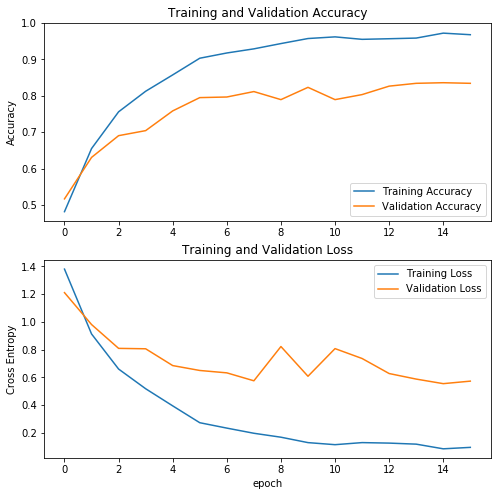

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
#print(f'Baseline accuracy: {custom_vgg_model.evaluate(X_valid, Y_valid)[1]}')
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [8]:
y_pred=model.predict_classes(X_val)
print(y_pred)
con_mat = tf.math.confusion_matrix(labels=y_val_onehot, predictions=y_pred)
print(con_mat)
print(len(y_pred))

[2 5 1 4 4 4 2 2 1 3 3 1 1 0 0 2 1 2 5 0 0 3 1 3 2 0 1 1 3 5 2 3 5 0 4 3 1
 3 0 3 0 3 5 5 4 1 0 3 5 4 0 0 3 4 0 0 2 1 3 0 3 5 4 5 2 5 2 3 0 0 1 4 1 0
 2 5 3 0 0 1 0 0 4 3 5 4 4 5 0 5 0 2 3 2 2 0 2 3 1 1 3 1 0 4 5 0 5 0 4 1 1
 0 5 1 1 2 5 3 2 2 1 5 1 0 5 5 0 5 5 4 4 3 0 3 4 3 3 0 5 2 3 4 5 3 3 2 4 5
 4 0 4 3 0 0 5 4 3 0 1 1 0 4 5 0 5 1 0 1 3 5 0 1 3 0 3 4 1 0 0 1 0 1 0 4 0
 4 3 3 5 5 0 2 1 1 2 2 4 5 5 5 4 0 1 1 4 1 5 2 1 1 3 5 1 1 5 3 5 5 3 0 1 2
 5 1 3 0 4 1 1 1 1 0 3 1 5 5 5 0 5 5 3 0 0 3 3 5 3 2 3 3 5 0 3 5 1 5 2 0 5
 0 0 1 1 5 3 1 1 1 4 4 5 5 0 4 0 4 2 5 0 0 5 5 1 1 1 0 2 0 2 4 1 0 1 3 4 3
 4 0 0 1 0 5 3 4 1 4 0 1 2 4 4 0 5 3 2 0 4 3 2 5 2 1 0 4 3 3 1 2 1 0 0 4 0
 3 3 5 5 3 1 3 3 2 3 1 4 0 3 1 0 4 1 1 0 2 1 0 3 0 0 0 3 2 1 5 3 5 3 4 5 2
 4 3 1 0 0 2 0 2 0 3 0 4 1 2 3 2 5 4 4 1 0 5 0 1 2 3 1 4 4 0 4 1 0 5 4 0 2
 4 1 3 3 5 0 5 5 1 2 2 4 3 4 2 2 2 0 5 0 3 5 5 5 4 4 5 1 4 1 2 2 0 0 3 1 2
 1 0 0 2 1 0 2 0 3 2 2 5 3 3 4 5 0 2 5 1 3 0 0 1 3 0 2 4 5 2 1 2 1 0 2 4 0
 0 0 0 2 4 5 0 1 5 1 4 1 

In [9]:

from sklearn.metrics import classification_report, confusion_matrix
target_names = ['anger', 'disgust','fear', 'happiness', 'sadness', 'surprise']
print(classification_report(y_val_onehot, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.27      0.33      0.30       139
     disgust       0.60      0.65      0.62       118
        fear       0.33      0.26      0.29       114
   happiness       0.57      0.61      0.59       104
     sadness       0.34      0.25      0.29       131
    surprise       0.20      0.22      0.21       110

    accuracy                           0.38       716
   macro avg       0.38      0.39      0.38       716
weighted avg       0.38      0.38      0.38       716



In [10]:
sess = tf.Session()
with sess.as_default():
        print(sess.run(con_mat))
        con_array = con_mat.eval(session=sess)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
classes=['anger','disgust','fear','happy','sad','surprise']
con_mat_norm = np.around(con_array.astype('float') / con_array.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                   columns = classes)

print(con_mat_df)
con_mat_df.to_pickle("confmat_LSTM.h5") 

[[46 13 22 21 15 22]
 [24 77  4  9  3  1]
 [29 11 30  4 15 25]
 [ 7  9 11 63  3 11]
 [35  9 15  2 33 37]
 [27 10 10 11 28 24]]
          anger  disgust  fear  happy   sad  surprise
anger      0.33     0.09  0.16   0.15  0.11      0.16
disgust    0.20     0.65  0.03   0.08  0.03      0.01
fear       0.25     0.10  0.26   0.04  0.13      0.22
happy      0.07     0.09  0.11   0.61  0.03      0.11
sad        0.27     0.07  0.11   0.02  0.25      0.28
surprise   0.25     0.09  0.09   0.10  0.25      0.22


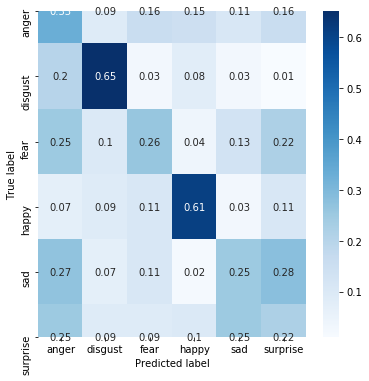

In [11]:
#matplotlib inline
figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
#sns.heatmap(con_mat_df, annot=True)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
#model.save('exp16.h5')
model.save('LSTM_May2.h5')

In [ ]:
##testing with no overlap 

# def process_frame(queue):
#     batchImages = np.stack(queue)
#     features = new_model.predict(batchImages)
#     return features

# def extract_features_woverlap(queue,label,i,vid_file_name, features_path):    
#     features_files = features_path
#     window = 0
#     for _ in range(len(queue)):
#         if len(queue[window:window+16]) < 8:  #discard frames if leftover is less than half the window 
#             break    
#         features = process_frame(queue[window:window+16])
#         print(np.shape(features),i)
#         class_label=label
#         output_filename = os.path.join(features_files, str(label), str(i) + '.pkl')
#         out = {'class_label': class_label, 'features': features, 'vid_file': vid_file_name}
#         with open(output_filename, 'wb') as w:
#             pkl.dump(out, w)
#         window += 16
#         i += 1
#     return i
    
# def extract_frames(file, source_path, vid_file_name,label,i,features_path):
#     video = cv2.VideoCapture(source_path)
#     count = 0
#     queue = []
#     while True:
#         (grabbed, frame) = video.read()
#         if not grabbed:
#             print("not grabbed")
#             break
        
#         faces = detector.detect_faces(frame)
#         if faces !=[]:
#             x1, y1, width, height = faces[0]['box']
#             x2, y2 = x1 + width, y1 + height
#             face = frame[y1:y2, x1:x2] 
#             frame = cv2.resize(face, (224, 224)).astype("float32")
#             #cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX)
#             norm_image = cv2.normalize(frame, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#             queue.append(norm_image)
#         if len(queue) >= 180:
#             break
#     #extract_features(queue, label, i)
#     i = extract_features_woverlap(queue,label,i, vid_file_name,features_path)
#     return(i)

# def video_fetch(dataset_path, features_path):
    
#     count_unknown, i = 0,0
#     queue = []
#     #detector = MTCNN()

#     t0 = time.time()

#     for (root,dirs,files) in os.walk(dataset_path, topdown=True): 
#         for file in files:
#             if str(file) != "Thumbs.db":
#                 if not str(file).startswith('.'):
#                     source_path = os.path.join(root,file)
#                     #print(source_path)
#                     if str(source_path).find("fear") > 0:
#                         #vid_file_name = 'fear{}'.format(i)+'.mp4'
#                         vid_file_name = str(file)
#                         label = "fear"

#                     elif str(source_path).find("happiness") > 0 :
#                         #vid_file_name = 'happiness{}'.format(i)+'.mp4'
#                         vid_file_name = str(file)
#                         label = "happiness"


#                     elif str(source_path).find("sadness") > 0:
#                         #print(str(root).find("sadness"))
#                         #vid_file_name = 'sadness{}'.format(i)+'.mp4'
#                         vid_file_name = str(file)
#                         label = "sadness"

#                     elif str(str(source_path)).find("surprise") > 0:
#                         #vid_file_name = 'surprise{}'.format(i)+'.mp4'
#                         vid_file_name = str(file)
#                         label = "surprise"

#                     elif str(str(source_path)).find("anger") > 0 :
#                         #vid_file_name = 'anger{}'.format(i)+'.mp4'
#                         vid_file_name = str(file)
#                         label = "anger"

#                     elif str(source_path).find("disgust") > 0 :
#                         #vid_file_name = 'disgust{}'.format(i)+'.mp4'
#                         vid_file_name = str(file)
#                         label = "disgust"

#                     else : 
#                         #print(str(source_path))
#                         vid_file_name = "unknown"
#                         count_unknown +=1

#                     if vid_file_name != "unknown":
#                         #print(vid_file_name)
#                         #pass
#                         i = extract_frames(file, source_path, vid_file_name, label,i,features_path)
#                         #extract_frames(file, source_path, vid_file_name, label,i)
#                         #frame_len = compute_frame_len(file, source_path, vid_file_name, label,i)
#                         #queue.append(frame_len)
#                         i += 1
#     print(count_unknown)
#     t1 = time.time()
#     print("time elapsed",t1-t0)

In [ ]:
# emotions = ['anger', 'disgust','fear', 'happiness', 'sadness', 'surprise']
# destination_path = "eInterface_dataset/eInterface/validation_features/features_overlap_16_nooverlap"
# #code to create directories in features folder
# for emotion in emotions :
#     destination_emotion = os.path.join(destination_path, emotion)
#     if os.path.exists(destination_emotion):
#         os.system('rm -rf {}'.format(destination_emotion))

#     if not os.path.exists(destination_emotion):
#         os.system('mkdir {}'.format(destination_emotion))


In [ ]:
# validation_dataset_path = "eInterface_dataset/modifed_ENTERFACE/validation_set"
# features_val_16_nooverlap = "eInterface_dataset/eInterface/validation_features/features_overlap_16_nooverlap"
# video_fetch(validation_dataset_path, features_val_16_nooverlap)